## Лабораторная работа №1. Backward-Propagation. 

Выполнил: **Кирилл Петров. ВМиСТ**

In [1]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import LabelBinarizer
import pandas as pd
from scipy.special import xlogy

## Forward-Propagation

Построим сеть следующего вида:

$$
X \rightarrow Z=W_1X \rightarrow U = W_2Z \rightarrow S=F_{softmax}(U) \rightarrow L(S, y) = -\log S_y,
$$

где $S_y=\frac{\exp(U_y)}{\sum_{j=0}^{K-1}\exp(U_j)}$; y-ый элемент $S$ и $U_y$ y-ый элемент $U$.

## Backward-Propagation

Посчитаем градиенты $\frac{\partial L}{\partial W_2}$ и $\frac{\partial L}{\partial W_1}$

$$
\frac{\partial L}{\partial U_t} =  
\begin{cases}
S_t(U), & t\neq y \\
1- S_t(U). & t = y
\end{cases}
\Longrightarrow
\frac{\partial L}{\partial U} = e_y - S(U), 
$$

где $e_y$ единичный вектор, где y-ый равный 1, если y, в противном случае 0. 

\begin{align}
& \frac{\partial L}{\partial W_2} = \frac{\partial L}{\partial U}\frac{\partial U}{\partial W_1} = (e_y - S(U))Z^T \\
& \frac{\partial L}{\partial W_1} = \frac{\partial L}{\partial U}\frac{\partial U}{\partial Z}\frac{\partial Z}{\partial W_1} = \big(\big(e_y - S(U)\big) \cdot W_2\big)X^T
\end{align}

Соорудим и реализуем небольшой класс, который реализует описанные выше действия с градиентным методом **Adagrad**:

Обозначим градиент по параметру $W_i$ на итерации $t$ как $g_{t,i} = \nabla_{W}L(W_i)$. 

В случае sgd обновление параметра $W_i$ будет выглядеть следующим образом:

$$ W_{t+1, i} = W_{t, i} - \eta \cdot g_{t,i}$$

А в случае Adagrad общий шаг $\eta$ нормируется на посчитанные ранее градиенты для данного параметра:

$$ W_{t+1, i} = W_{t, i} - \dfrac{\eta}{\sqrt{G_{t,ii} + \varepsilon}} \cdot g_{t,i}$$

где $G_t$ — диагональная матрица, где каждый диагональный элемент $i,i$ — сумма квадратов градиентов для $W_{i}$ до $t$-ой итерации. $\varepsilon$ — гиперпараметр, позволяющий избежать деления на 0 (обычно выбирается около *1e-8*).

Так как матрица $G_t$ диагональна, в векторном виде это будет выглядеть следующим образом (здесь $\odot$ — матричное умножение):

$$ W_{t+1} = W_{t} - \dfrac{\eta}{\sqrt{G_t + \varepsilon}} \odot g_t $$

Инициализацию весов проводил по правилу xavier (брал из этой [статьи](https://towardsdatascience.com/weight-initialization-in-neural-networks-a-journey-from-the-basics-to-kaiming-954fb9b47c79)) : $ Uniform(-a; a) $
Где
$$
a = \frac{\sqrt 6}{\sqrt{n_i + n_{i+1}}}
$$


In [12]:
class DNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, hidden_layer_sizes=(100), solver='adagrad',
                 batch_size=1, learning_rate=0.001, momentum=0.9, eps=1e-8,
                 max_iter=200, random_state=32, shuffle=True, verbose=False):
        self.batch_size = batch_size
        self.max_iter = max_iter
        self.hidden_layer_sizes = hidden_layer_sizes
        self.momentum = momentum
        self.eps = eps
        self.learning_rate = learning_rate
        self.random_state = random_state
        self.shuffle = shuffle
        self.verbose = verbose

    def __stable_softmax(self, x):
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        return x / x.sum(axis=1, keepdims=True)

    def __crossentropy_loss(self, y_true, y_prob):
        return - xlogy(y_true, y_prob).sum()

    def __forward_layer(self, x, w, activation_function):
        out = np.dot(x, w)
        if activation_function is not None:
            out = activation_function(out)
        return out

    def __forward_propagate(self, x):
        weights = self.weights
        out_activations = [x]
        for weight, activataion in zip(weights, self.functions):
            out = self.__forward_layer(out_activations[-1], weight, activataion)
            out_activations.append(out)
        return out_activations

    def __back_propagation(self, activations, y):
        weights = self.weights
        coef_grads = [np.empty_like(a_layer) for a_layer in weights]

        deltas = activations[-1] - y
        coef_grads[-1] = np.dot(activations[-2].T, deltas)

        for i in range(len(weights)-2, -1, -1):
            deltas =  np.dot(deltas, weights[i + 1].T)
            coef_grads[i] = np.dot(activations[i].T, deltas)

        return coef_grads

    def __init_layer(self, input_size, output_size):
        a = np.sqrt(6.0 / (input_size + output_size))
        w = np.random.uniform(-a, a, (input_size, output_size))
        return w

    def fit(self, X, y):
        np.random.seed(self.random_state)

        self._label_binarizer = LabelBinarizer()
        y_train = y
        X_train = X
        y = self._label_binarizer.fit_transform(y)
        self._num_classes = len(self._label_binarizer.classes_)

        n, p = X.shape
        s = self.hidden_layer_sizes[0]

        self.weights = [
            self.__init_layer(p, s),
            self.__init_layer(s, self._num_classes)
        ]

        self.functions = [
            None,
            self.__stable_softmax,
        ]

        accum_grad = [np.zeros_like(param) for param in self.weights]

        for j in range(self.max_iter):
            accumulated_loss = 0.0

            if self.shuffle:
                indices = np.arange(n)
                np.random.shuffle(indices)
                X = X.take(indices, axis=0)
                y = y.take(indices, axis=0)
            
            for i in range(0, n, self.batch_size):
                X_batch = X[i : i + self.batch_size]
                y_batch = y[i : i + self.batch_size]

                activations = self.__forward_propagate(X_batch)

                y_prob = activations[-1]

                accumulated_loss += self.__crossentropy_loss(y_batch, y_prob)
                coef_grads = self.__back_propagation(activations, y_batch)

                coef_grads = [grad / self.batch_size for grad in coef_grads]
                accum_grad = [accum + grad**2 for accum, grad in zip(accum_grad, coef_grads)]
                inv_accum_grad = [self.learning_rate / np.sqrt(self.eps + accum) for accum in accum_grad]
                self.weights = [weight - inv_accum * grad for weight, inv_accum, grad in zip(self.weights, inv_accum_grad, coef_grads)]

            if self.verbose:
                loss = accumulated_loss / X.shape[0]
                y_pred = self.predict(X_train)
                accuracy = (y_pred == y_train).mean()
                print("Epoch {}/{};\t Train accuracy: {:.3f} \t Loss : {:.3f}".format(j + 1, self.max_iter, accuracy, loss))

        return self

    def predict(self, X):
        activations = self.__forward_propagate(X)
        y_pred = activations[-1]
        return self._label_binarizer.inverse_transform(y_pred)

## Read datasets

In [5]:
from sklearn.datasets import fetch_mldata

data_train = pd.read_csv("../dataset/mldata/mnist_train.csv", header=None)
data_test = pd.read_csv("../dataset/mldata/mnist_test.csv", header=None)

x_train = np.ascontiguousarray(data_train[data_train.columns[:-1]].values, dtype=np.float32)
y_train = np.ascontiguousarray(data_train[data_train.columns[-1]].values, dtype=np.float32)
x_test = np.ascontiguousarray(data_test[data_test.columns[:-1]].values, dtype=np.float32)
y_test = np.ascontiguousarray(data_test[data_test.columns[-1]].values, dtype=np.float32)

print('train size: ', x_train.shape, y_train.shape)
print('test size: ', x_test.shape, y_test.shape)

train size:  (60000, 784) (60000,)
test size:  (10000, 784) (10000,)


## Normalize datasets

Чтобы веса не улетали в большие значения, нормируем датасет:

In [6]:
x_train /= 255
x_test /= 255

## Check of Neural Network

Проверим работу сети:

In [15]:
%%time
clf = DNNClassifier(hidden_layer_sizes=(100,), max_iter=10, solver='adagrad',
     batch_size=256, learning_rate=0.05, random_state=777, shuffle=True, verbose=True)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print()
print('Accuracy на тестовой выборке: ', (y_pred == y_test).mean())

Epoch 1/10;	 Train accuracy: 0.918 	 Loss : 0.626
Epoch 2/10;	 Train accuracy: 0.925 	 Loss : 0.293
Epoch 3/10;	 Train accuracy: 0.927 	 Loss : 0.278
Epoch 4/10;	 Train accuracy: 0.927 	 Loss : 0.272
Epoch 5/10;	 Train accuracy: 0.930 	 Loss : 0.267
Epoch 6/10;	 Train accuracy: 0.931 	 Loss : 0.263
Epoch 7/10;	 Train accuracy: 0.930 	 Loss : 0.260
Epoch 8/10;	 Train accuracy: 0.931 	 Loss : 0.257
Epoch 9/10;	 Train accuracy: 0.931 	 Loss : 0.256
Epoch 10/10;	 Train accuracy: 0.932 	 Loss : 0.254

Accuracy на тестовой выборке:  0.9253
Wall time: 29 s


Ну видно, что сеть работает и при том, хорошо - **Loss уменьшается**, **accuracy** на тренировочной выборке **растет**. Да и **работает** довольно **быстро**. Я доволен :) Осталось подтюнить гиперпараметры.

## Grid search parameters for Neural Network

Теперь, нашей сетью, попробуем подобрать оптимальные гиперпараметры по размеру скрытого слоя.

In [7]:
from sklearn.model_selection import GridSearchCV

In [23]:
parameters = {
    'hidden_layer_sizes': [(16,), (32,), (48,), (64,), (76,), (92,)],
}

estimator = DNNClassifier(solver='adagrad',
     batch_size=256, learning_rate=0.05, max_iter=50,
     random_state=777, verbose=False)

grid_clf = GridSearchCV(estimator, parameters, cv=5, scoring='accuracy')
grid_clf.fit(x_train, y_train)
print("Лучший подбор параметра для DNNClassifier: {}".format(grid_clf.best_params_))
print("Лучший scope для DNNClassifier: {}".format(grid_clf.best_score_))

Лучший подбор параметра для DNNClassifier: {'hidden_layer_sizes': (16,)}
Лучший scope для DNNClassifier: 0.92155


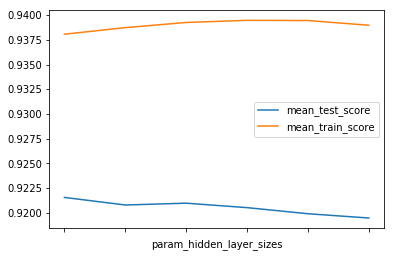

In [20]:
pd.DataFrame(grid_clf.cv_results_).plot(x='param_hidden_layer_sizes', y=[ 'mean_test_score', 'mean_train_score'])
pass

Видно, что при большом числе нейронов в скрытом слое мы наблюдаем **переобучение**. Возьмем количетсво нейронов, в самом оптимальном варианте (16).

In [21]:
best_estimator = grid_clf.best_estimator_
up_params = {'verbose': True, 'max_iter': 30}
best_estimator.set_params(**up_params)
best_estimator

DNNClassifier(batch_size=256, eps=1e-08, hidden_layer_sizes=(16,),
       learning_rate=0.05, max_iter=30, momentum=0.9, random_state=777,
       shuffle=True, solver=None, verbose=True)

In [22]:
%%time
best_estimator.fit(x_train, y_train)

Epoch 1/30;	 Train accuracy: 0.914 	 Loss : 0.448
Epoch 2/30;	 Train accuracy: 0.921 	 Loss : 0.299
Epoch 3/30;	 Train accuracy: 0.923 	 Loss : 0.283
Epoch 4/30;	 Train accuracy: 0.926 	 Loss : 0.275
Epoch 5/30;	 Train accuracy: 0.928 	 Loss : 0.270
Epoch 6/30;	 Train accuracy: 0.929 	 Loss : 0.266
Epoch 7/30;	 Train accuracy: 0.929 	 Loss : 0.263
Epoch 8/30;	 Train accuracy: 0.930 	 Loss : 0.261
Epoch 9/30;	 Train accuracy: 0.931 	 Loss : 0.259
Epoch 10/30;	 Train accuracy: 0.929 	 Loss : 0.257
Epoch 11/30;	 Train accuracy: 0.932 	 Loss : 0.256
Epoch 12/30;	 Train accuracy: 0.932 	 Loss : 0.254
Epoch 13/30;	 Train accuracy: 0.932 	 Loss : 0.253
Epoch 14/30;	 Train accuracy: 0.933 	 Loss : 0.252
Epoch 15/30;	 Train accuracy: 0.933 	 Loss : 0.251
Epoch 16/30;	 Train accuracy: 0.933 	 Loss : 0.250
Epoch 17/30;	 Train accuracy: 0.933 	 Loss : 0.249
Epoch 18/30;	 Train accuracy: 0.934 	 Loss : 0.249
Epoch 19/30;	 Train accuracy: 0.933 	 Loss : 0.248
Epoch 20/30;	 Train accuracy: 0.934 	 Lo

DNNClassifier(batch_size=256, eps=1e-08, hidden_layer_sizes=(16,),
       learning_rate=0.05, max_iter=30, momentum=0.9, random_state=777,
       shuffle=True, solver=None, verbose=True)

## Accuracy for testing datasets

Ну и финальное аккураси:

In [24]:
y_pred = best_estimator.predict(x_test)
print('Accuracy на тестовой выборке: ', (y_pred == y_test).mean())

Accuracy на тестовой выборке:  0.926


## Versus the sklearn MLP

Сравним нашу сеть, с какой нибудь библиотекой. Для простоты пускай это будет *sklearn*. И подбрем аналогично нашей сети параметры:

In [25]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(16,), max_iter=30, alpha=0, activation='identity',
                     batch_size=256, solver='adam', verbose=1, random_state=777,
                     tol=0, shuffle=True)
clf.fit(x_train, y_train)

Iteration 1, loss = 0.73436694
Iteration 2, loss = 0.35062043
Iteration 3, loss = 0.30739383
Iteration 4, loss = 0.28902413
Iteration 5, loss = 0.27904313
Iteration 6, loss = 0.27252593
Iteration 7, loss = 0.26722828
Iteration 8, loss = 0.26373192
Iteration 9, loss = 0.26013310
Iteration 10, loss = 0.25787084
Iteration 11, loss = 0.25518767
Iteration 12, loss = 0.25345777
Iteration 13, loss = 0.25129781
Iteration 14, loss = 0.25017786
Iteration 15, loss = 0.24874089
Iteration 16, loss = 0.24708613
Iteration 17, loss = 0.24613000
Iteration 18, loss = 0.24500568
Iteration 19, loss = 0.24473631
Iteration 20, loss = 0.24350242
Iteration 21, loss = 0.24221757
Iteration 22, loss = 0.24145957
Iteration 23, loss = 0.24186943
Iteration 24, loss = 0.24089721
Iteration 25, loss = 0.23973297
Iteration 26, loss = 0.23929363
Iteration 27, loss = 0.23851964
Iteration 28, loss = 0.23824422
Iteration 29, loss = 0.23767271
Iteration 30, loss = 0.23757961


MLPClassifier(activation='identity', alpha=0, batch_size=256, beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(16,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=30, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=777, shuffle=True, solver='adam', tol=0,
       validation_fraction=0.1, verbose=1, warm_start=False)

In [26]:
y_pred = clf.predict(x_test)
print('Accuracy на тестовой выборке: ', (y_pred == y_test).mean())

Accuracy на тестовой выборке:  0.9267


Почти аналогичный результат, схожей с моей моделью. Лучше аккураси получается при **нелинейной** функции активации после скрытого слоя, например ReLU.

In [27]:
clf = MLPClassifier(hidden_layer_sizes=(16,), max_iter=30, alpha=0, activation='relu',
                     batch_size=256, solver='adam', verbose=10, random_state=777,
                     tol=0, shuffle=True)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print('Accuracy на тестовой выборке: ', (y_pred == y_test).mean())

Iteration 1, loss = 0.81596686
Iteration 2, loss = 0.35609414
Iteration 3, loss = 0.29645522
Iteration 4, loss = 0.26542929
Iteration 5, loss = 0.24571562
Iteration 6, loss = 0.23178049
Iteration 7, loss = 0.22053985
Iteration 8, loss = 0.21187050
Iteration 9, loss = 0.20409084
Iteration 10, loss = 0.19801073
Iteration 11, loss = 0.19210298
Iteration 12, loss = 0.18623756
Iteration 13, loss = 0.17910247
Iteration 14, loss = 0.17381358
Iteration 15, loss = 0.16914523
Iteration 16, loss = 0.16547316
Iteration 17, loss = 0.16175265
Iteration 18, loss = 0.15866246
Iteration 19, loss = 0.15524834
Iteration 20, loss = 0.15315301
Iteration 21, loss = 0.15055781
Iteration 22, loss = 0.14809033
Iteration 23, loss = 0.14636946
Iteration 24, loss = 0.14425310
Iteration 25, loss = 0.14191990
Iteration 26, loss = 0.14030226
Iteration 27, loss = 0.13819602
Iteration 28, loss = 0.13657976
Iteration 29, loss = 0.13528631
Iteration 30, loss = 0.13427411
Accuracy на тестовой выборке:  0.9502
